In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(
    style='whitegrid',
    font_scale=0.9,
    rc={'lines.linewidth': 1.4, 'lines.markersize': 1.6},
    font='serif',
)
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
jtplot.style(context='notebook', fscale=1, spines=False, gridlines='--')
from mpl_toolkits import mplot3d

In [5]:
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import maszcal.twohalo
import maszcal.emulate
import maszcal.interp_utils
import maszcal.interpolate
import maszcal.cosmology
import maszcal.corrections
import supercubos
import projector
import pality

In [22]:
#zs = np.linspace(0, 1, 24)
#mus = np.linspace(np.log(0.3e14), np.log(5e14), 24)

param_mins = np.array([0, np.log(1e13)])
param_maxes = np.array([1.1, np.log(1e15)])

sample = supercubos.LatinSampler().get_lh_sample(
    param_mins=param_mins,
    param_maxes=param_maxes,
    num_samples=800,
)

zs, mus = sample.T

sort_index = zs.argsort()
inverse_index = sort_index.argsort()
zs = zs[sort_index]
mus = mus[sort_index]

cosmo_params = maszcal.cosmology.CosmoParams()

two_halo = maszcal.twohalo.TwoHaloConvergenceModel(
    cosmo_params=cosmo_params,
)

In [23]:
r_grid = np.geomspace(1e-2, 100, 120)
sds_2h = two_halo.radius_space_convergence(r_grid, zs, mus)
sds_2h = sds_2h[inverse_index, :]

In [24]:
sds_2h[sds_2h<0]

array([], dtype=float64)

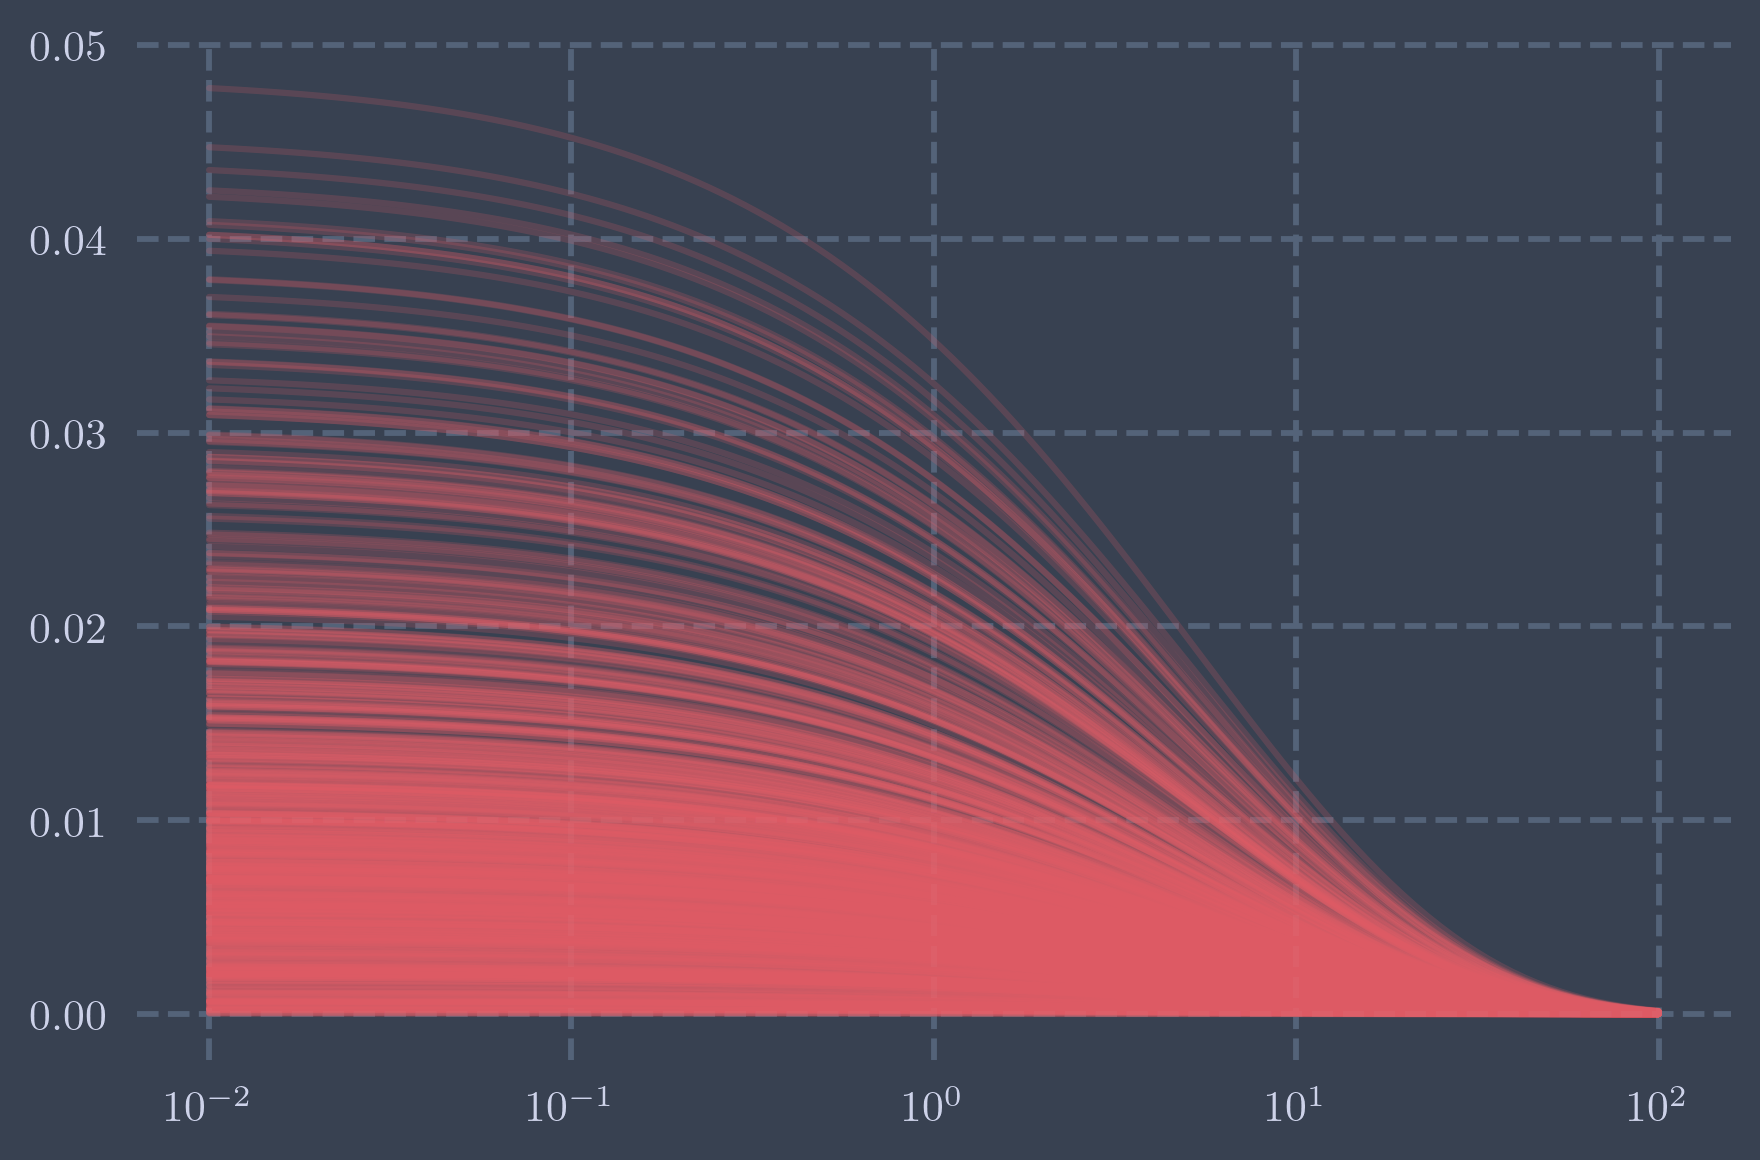

In [25]:
colors = ['#e25f69', '#77be4a', '#5794e4', '#c0af47', '#63c08d', '#d58040']

plt.plot(r_grid, sds_2h.T, alpha=0.2, color=colors[0], linestyle='-')
plt.gcf().set_size_inches(6, 4)
plt.xscale('log')

In [26]:
emulator = maszcal.emulate.PcaEmulator.create_from_data(
    sample,
    sds_2h.T,
    interpolator_class=maszcal.interpolate.RbfInterpolator,
    num_components=6
)

In [27]:
emulator.explained_variance.sum()

0.9999999999999997

In [28]:
sample_test = supercubos.LatinSampler().get_rand_sample(
    param_mins=param_mins,
    param_maxes=param_maxes,
    num_samples=1000,
)
zs_test, mus_test = sample_test.T

sort_index_test = zs_test.argsort()
inverse_index_test = sort_index_test.argsort()
zs_test = zs_test[sort_index_test]
mus_test = mus_test[sort_index_test]

two_halo = maszcal.twohalo.TwoHaloConvergenceModel(
    cosmo_params=cosmo_params,
)
sds_2h_test = two_halo.radius_space_convergence(r_grid, zs_test, mus_test)
sds_2h_test = sds_2h_test[inverse_index_test, :]

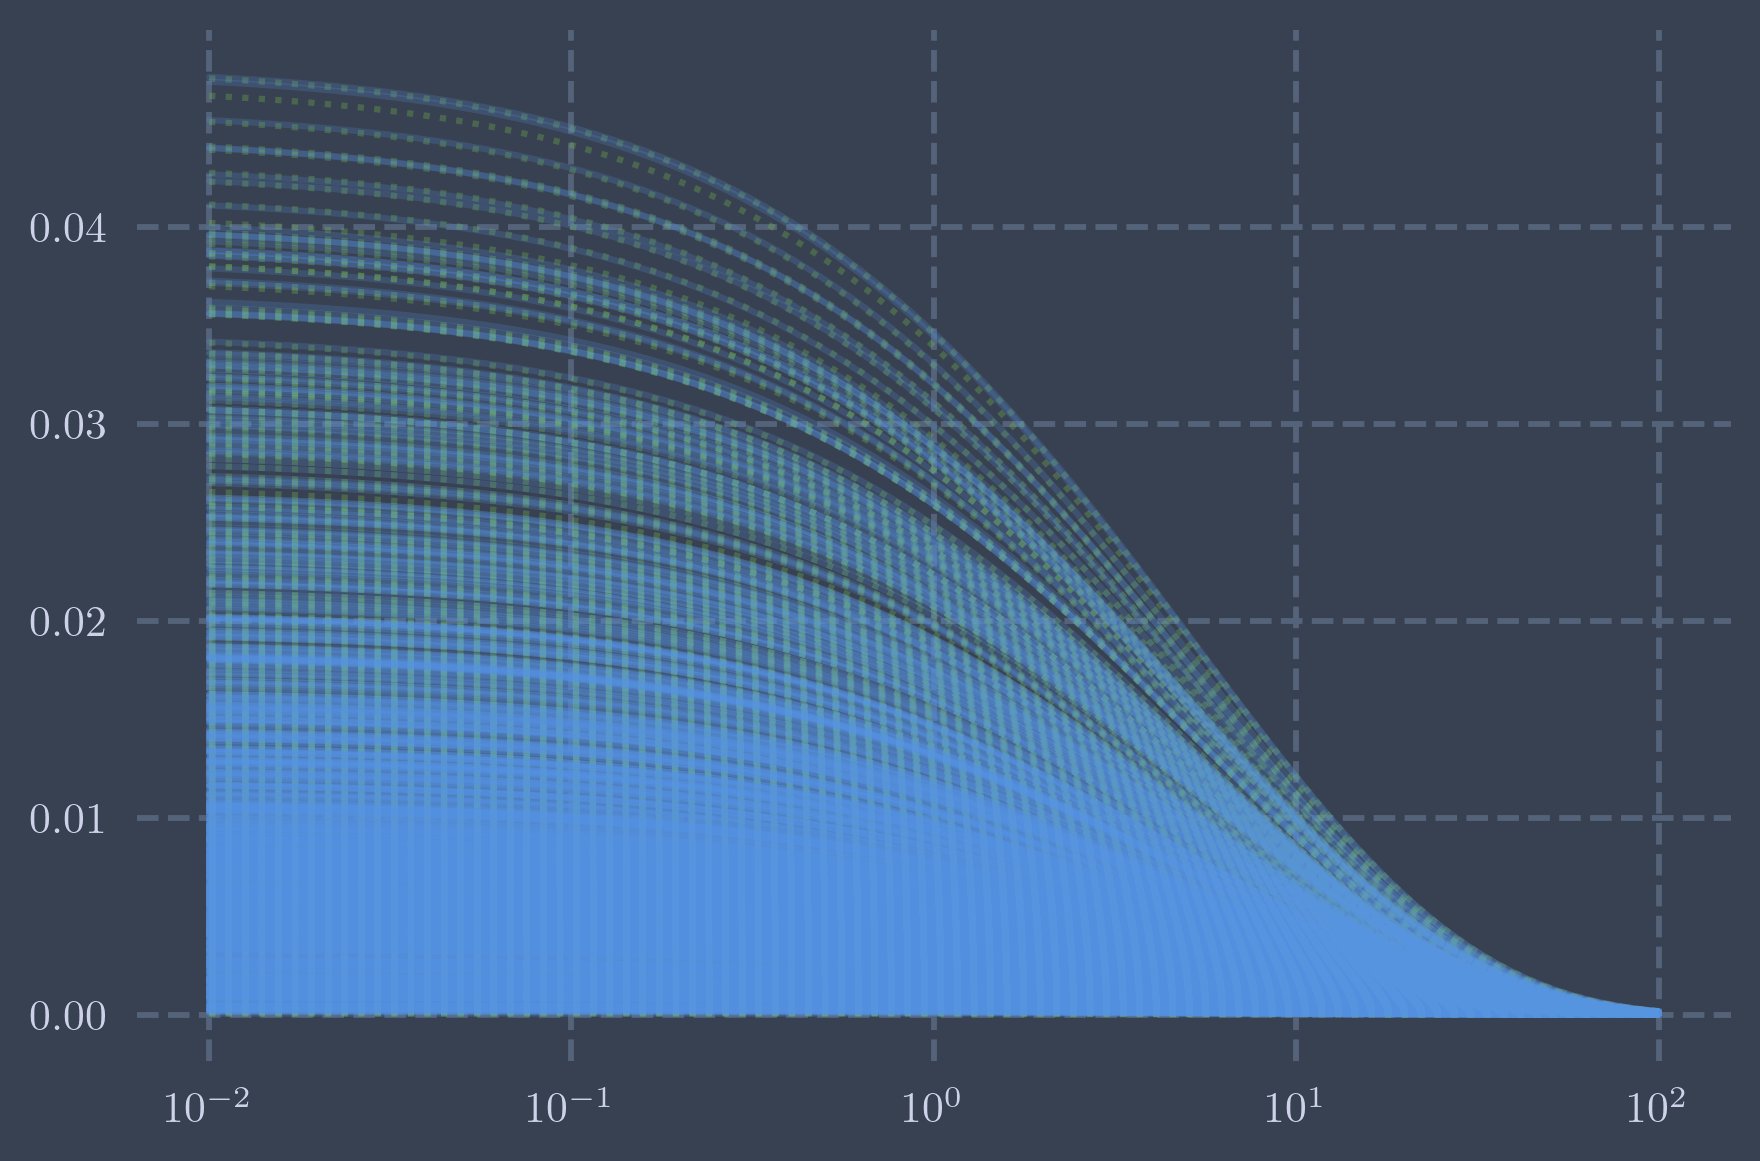

In [29]:
plt.plot(r_grid, sds_2h_test.T, alpha=0.3, color=colors[1], linestyle=':')
plt.plot(r_grid, emulator(sample_test), alpha=0.2, color=colors[2])
#plt.plot(rs, data_test.T, alpha=0.8, color='grey', linestyle='--')
plt.gcf().set_size_inches(6, 4)
plt.xscale('log')

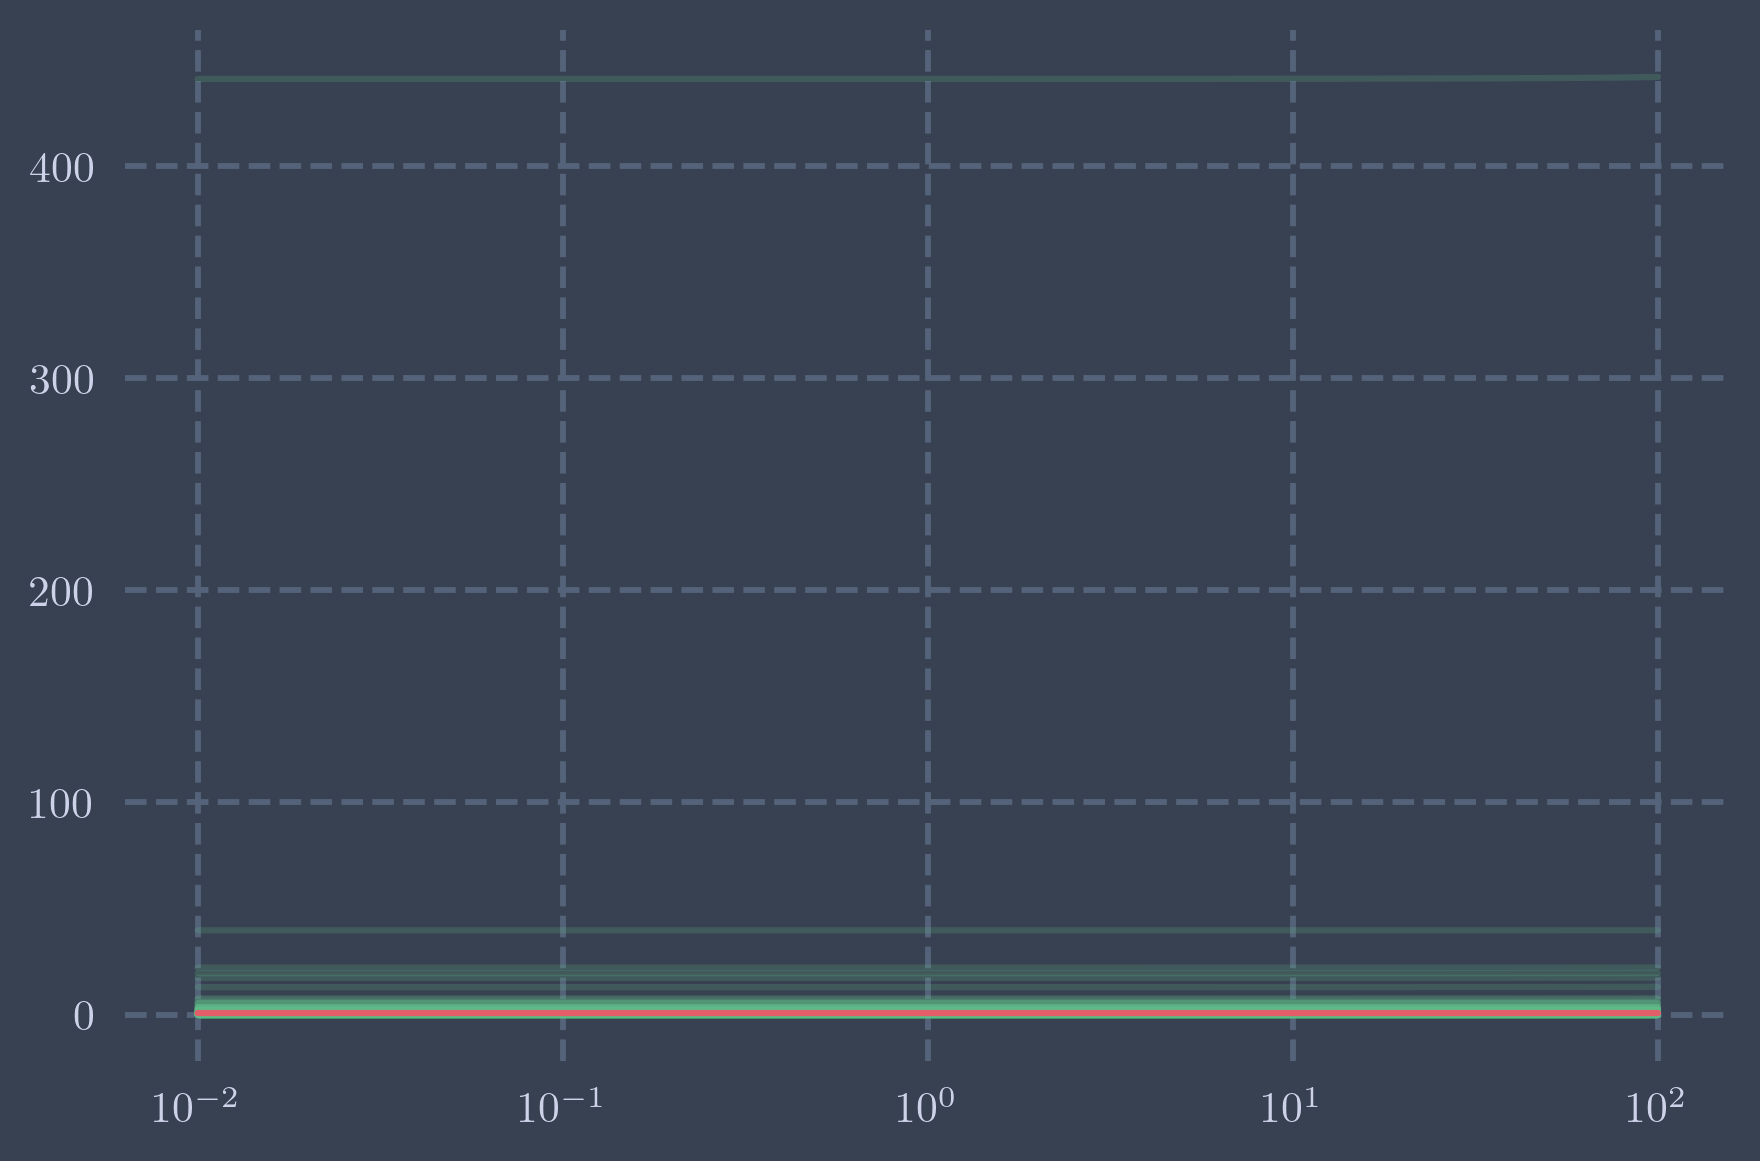

In [30]:
err = (emulator(sample_test).T - sds_2h_test)/sds_2h_test
plt.plot(r_grid, 100*np.abs(err.T), alpha=0.2, color=colors[4])
plt.plot(r_grid, 100*np.abs(err.T).mean(axis=-1), alpha=1, color=colors[0])
plt.gcf().set_size_inches(6, 4)
plt.xscale('log')

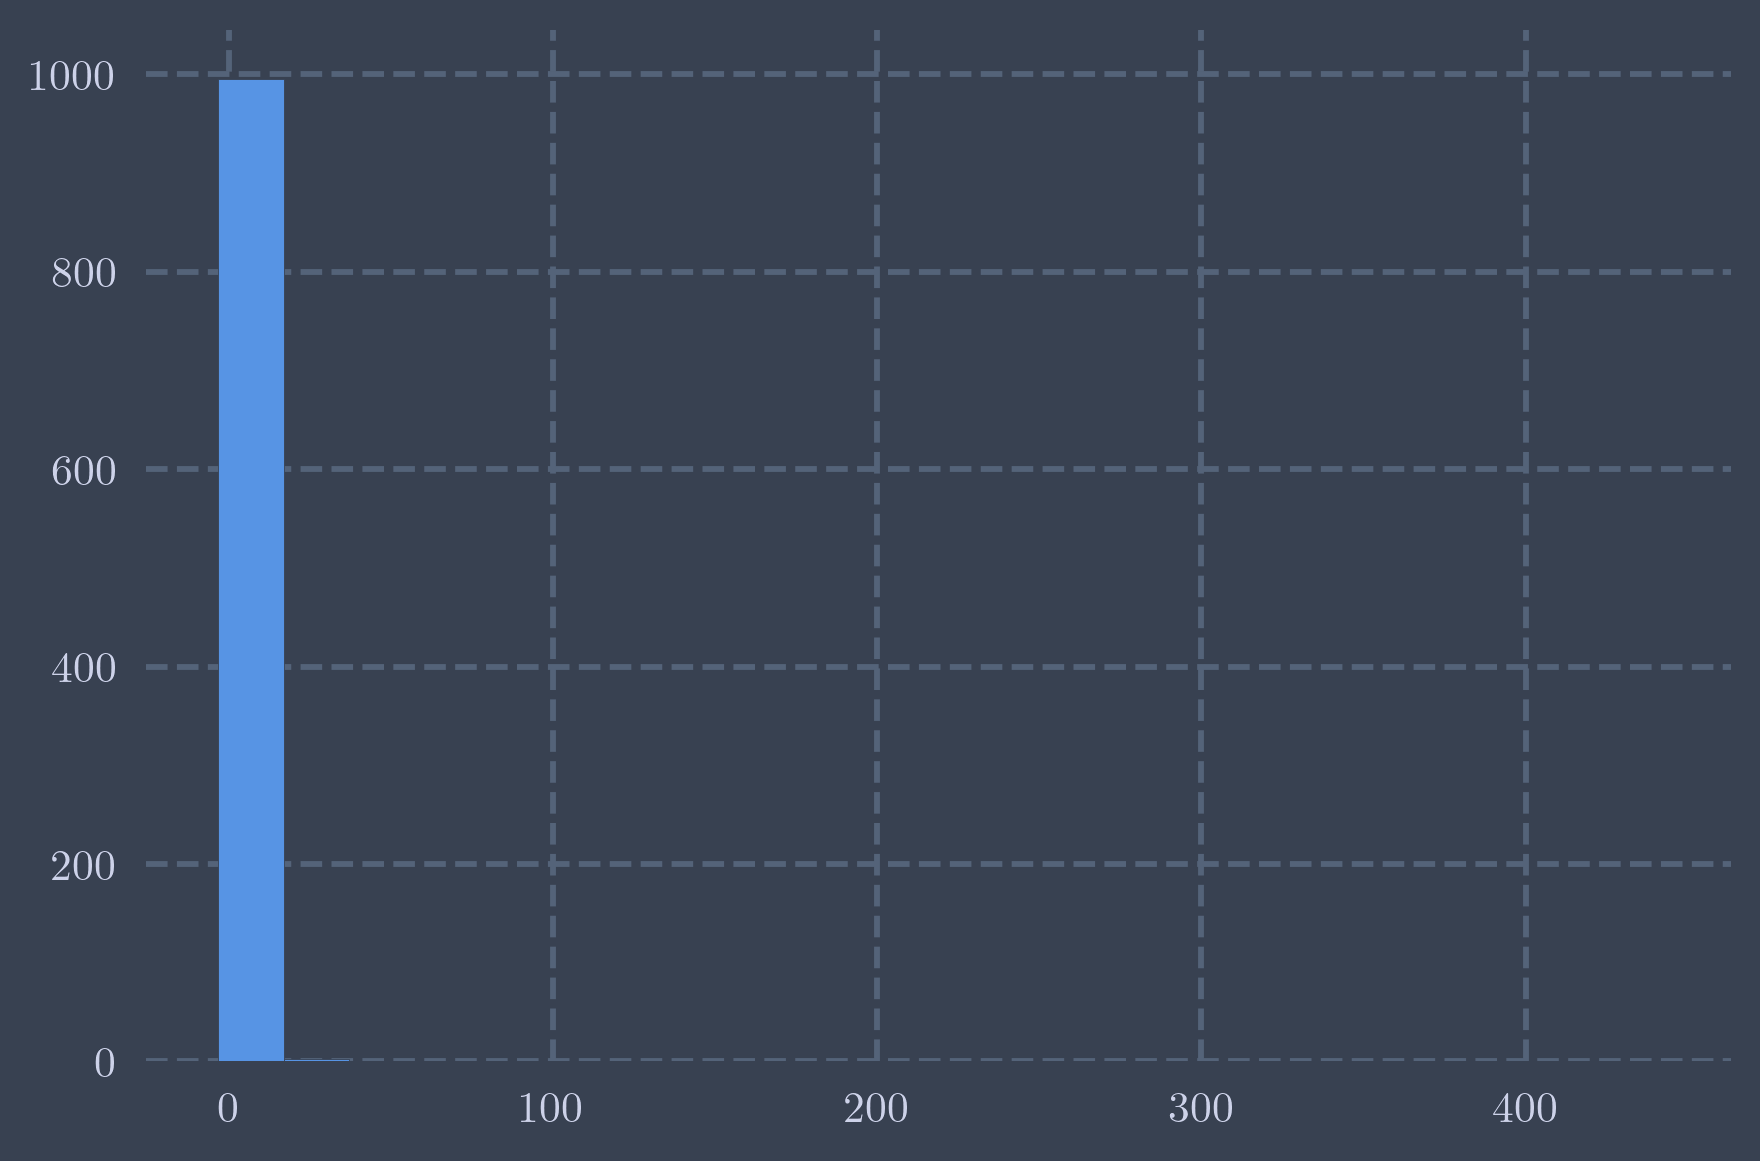

In [31]:
plt.hist(100*err.mean(axis=-1), color=colors[2], bins=22)
plt.gcf().set_size_inches(6, 4)

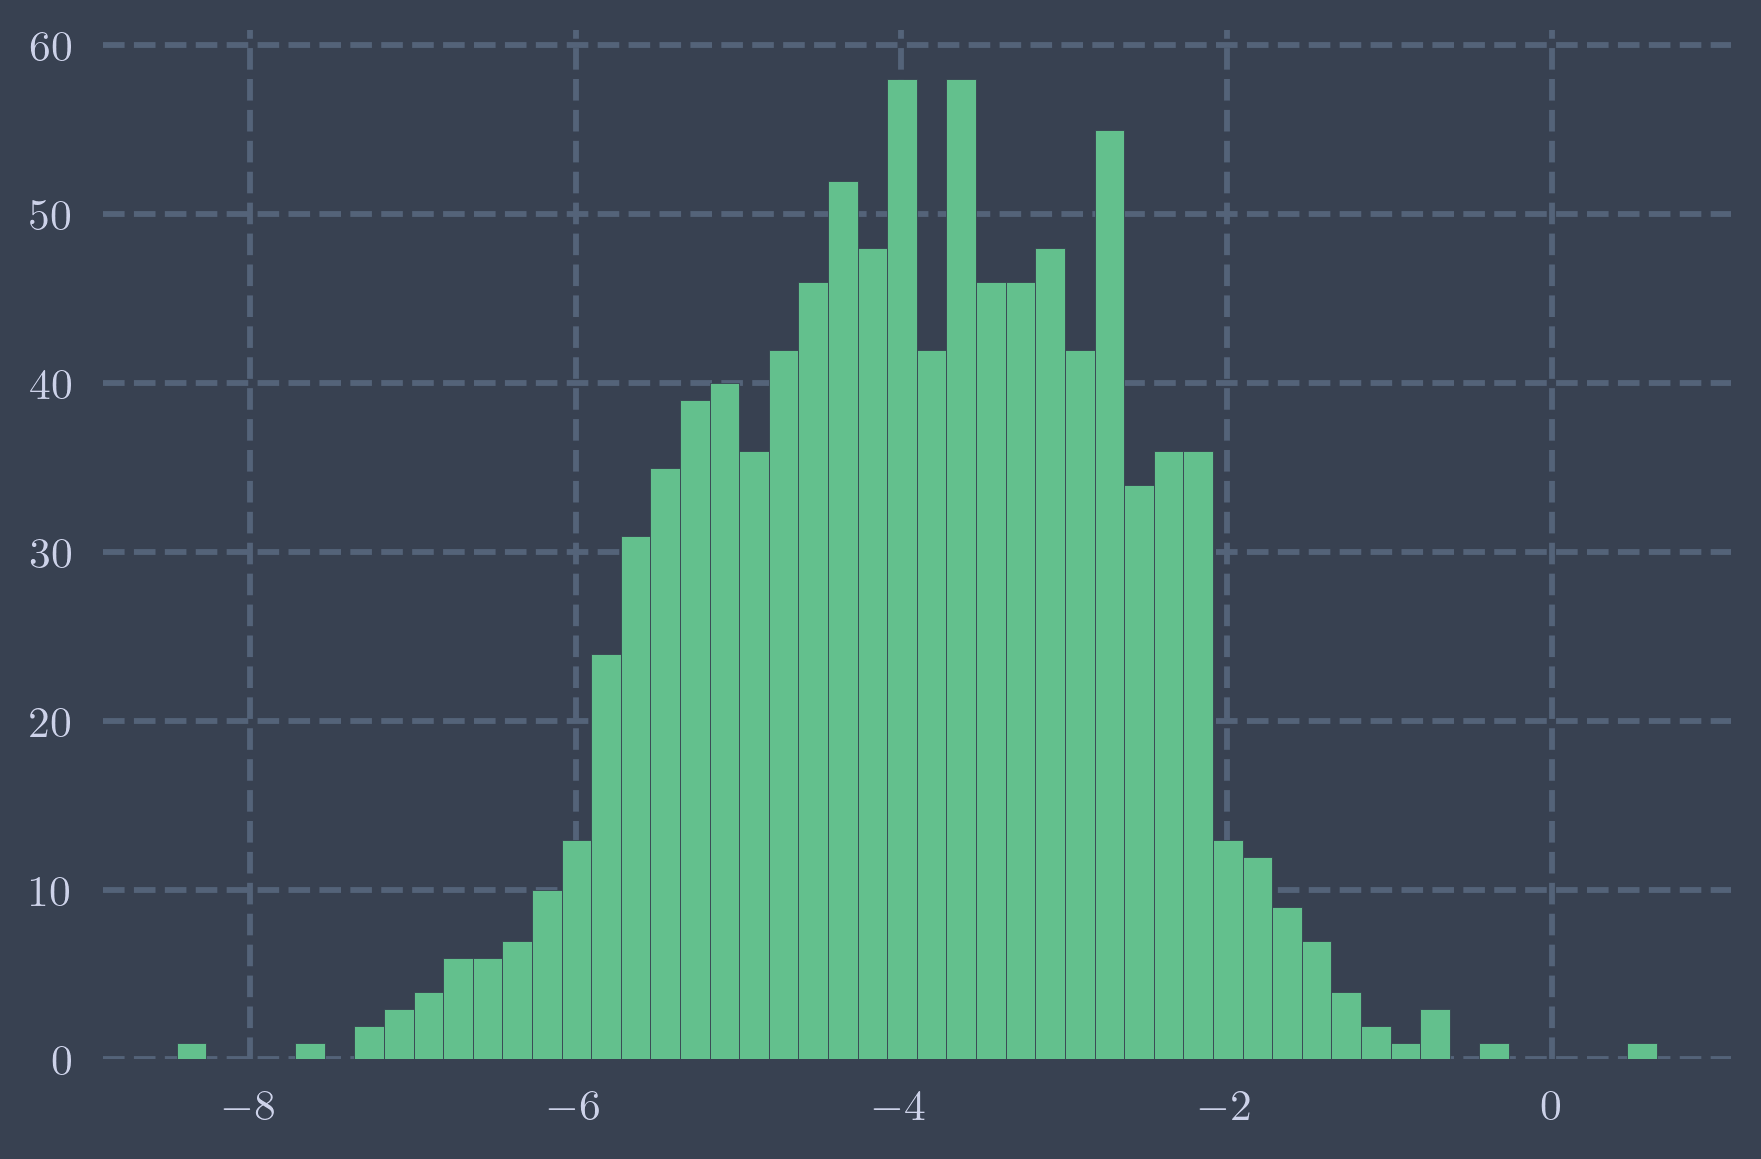

In [32]:
plt.hist(np.log10(np.abs(err.mean(axis=-1))), color=colors[4], bins=50)
plt.gcf().set_size_inches(6, 4)

In [33]:
mean_abs_err = np.abs(err.mean(axis=-1))
100*mean_abs_err[100*mean_abs_err>1].size/mean_abs_err.size

4.5

In [34]:
def emu(zs, mus):
    return emulator(np.stack((zs, mus)).T).T

In [35]:
import scipy.interpolate

In [36]:
radial_interpolator = scipy.interpolate.interp1d(
    r_grid,
    emu(zs_test, mus_test),
    kind='cubic',
    axis=-1,
)

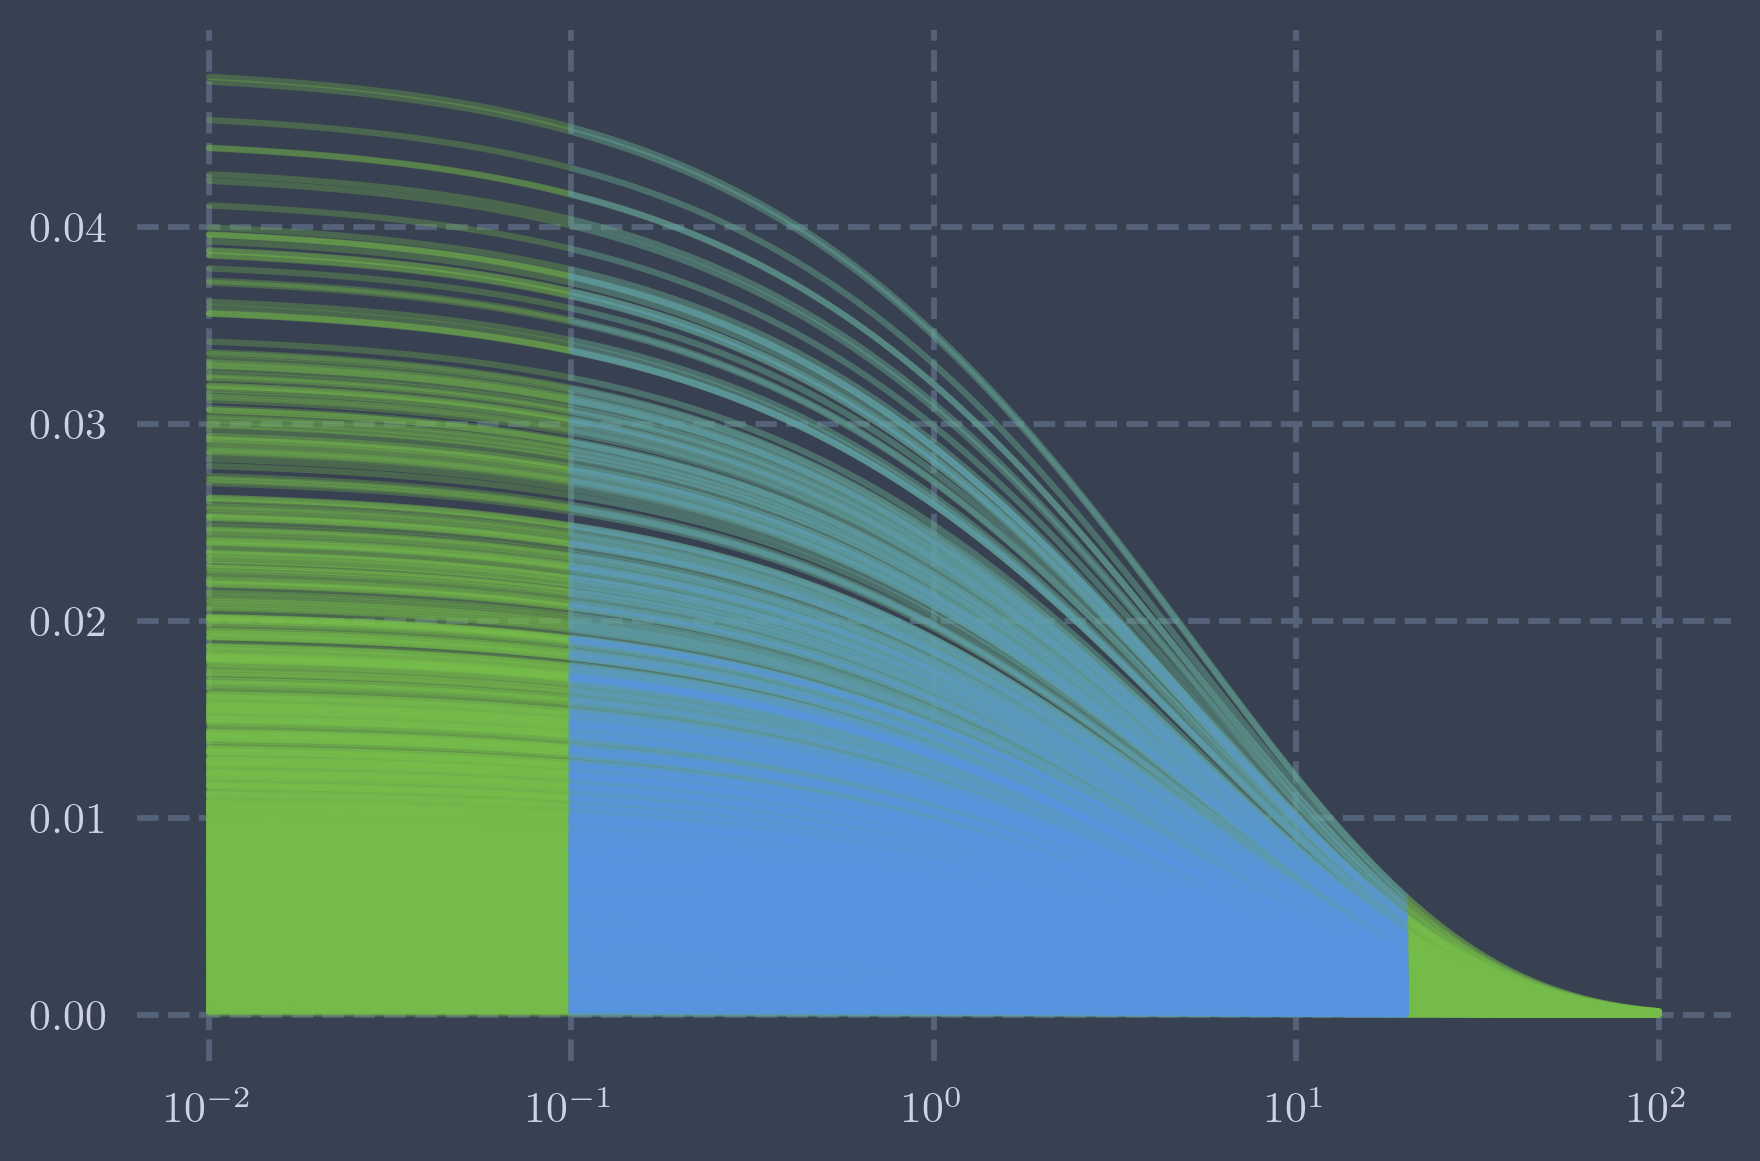

In [37]:
rs = np.geomspace(1e-1, 20, 64)

plt.plot(r_grid, emu(zs_test, mus_test).T, alpha=0.3, color=colors[1], linestyle='-')
plt.plot(rs, radial_interpolator(rs).T, alpha=0.2, color=colors[2])
#plt.plot(rs, data_test.T, alpha=0.8, color='grey', linestyle='--')
plt.gcf().set_size_inches(6, 4)
plt.xscale('log')